In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.max_open_warning'] = 91

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

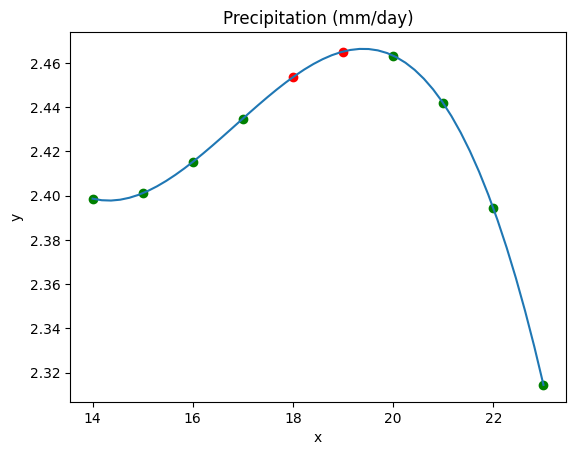

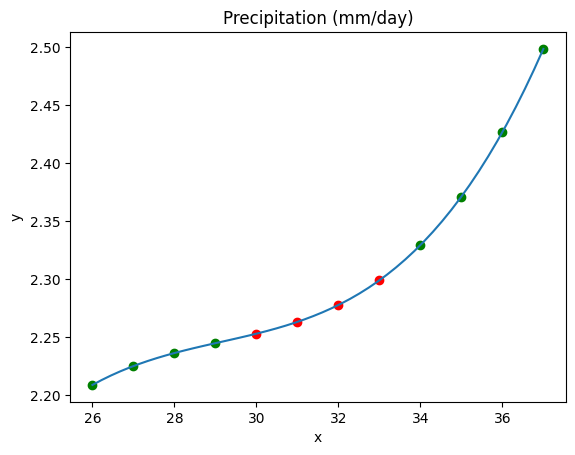

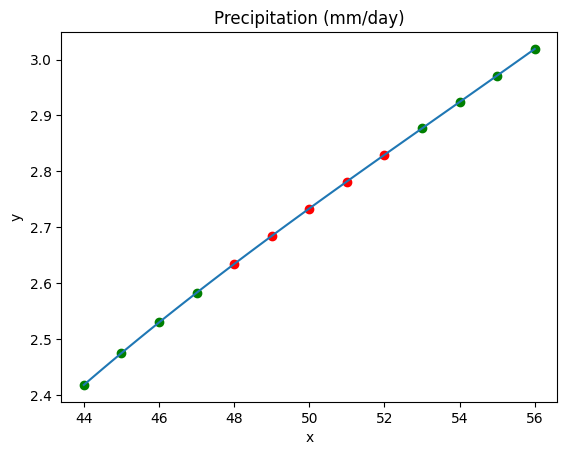

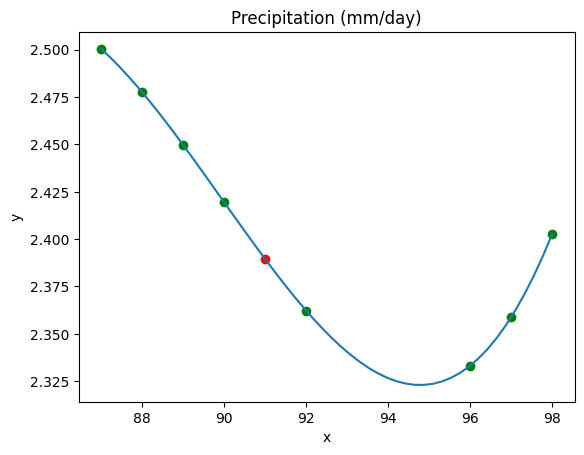

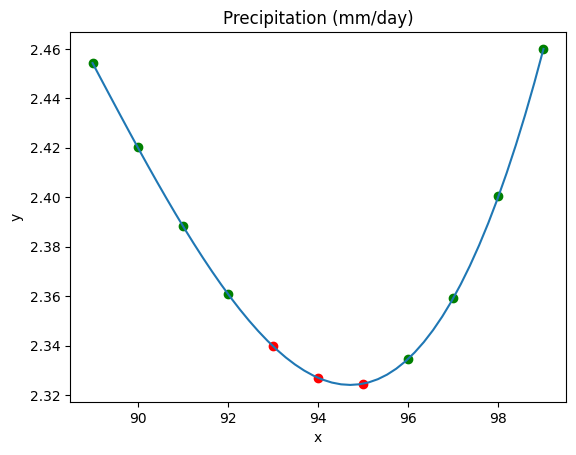

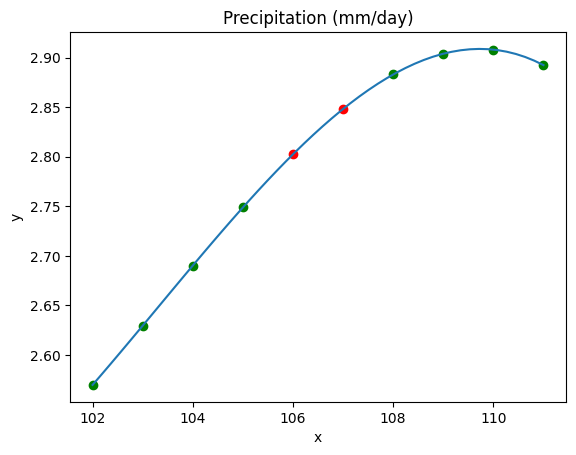

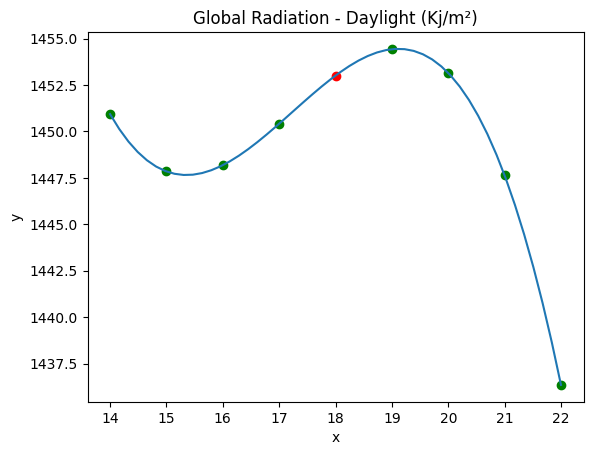

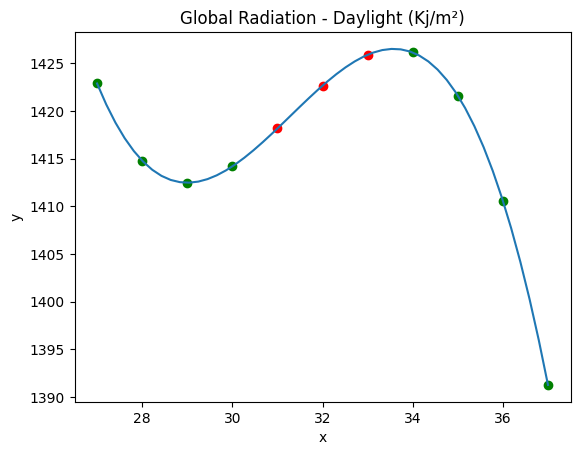

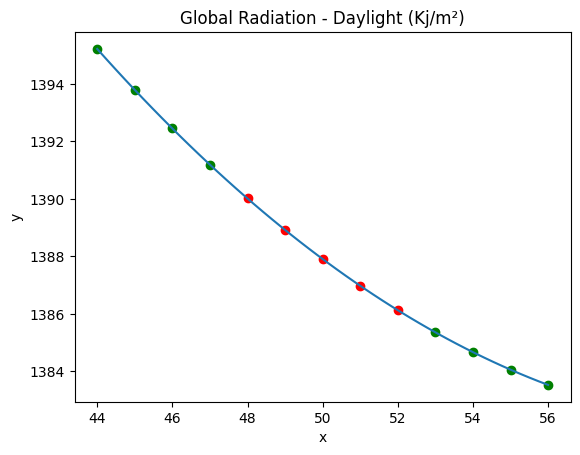

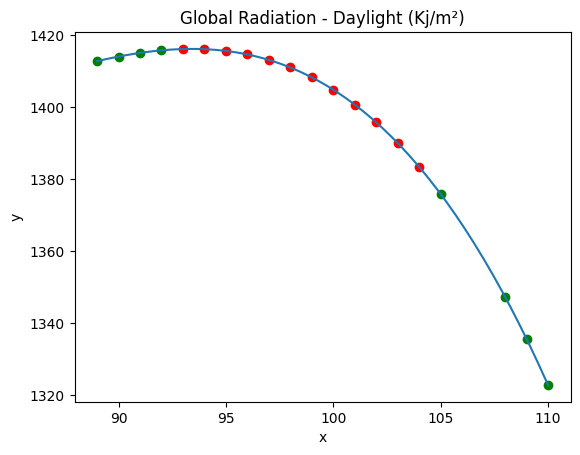

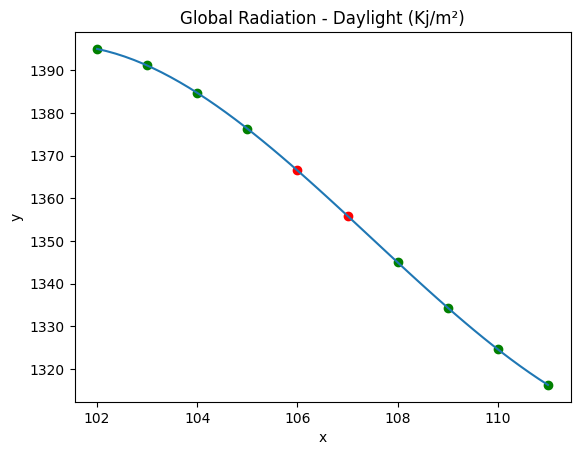

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
0,2001,3.031573,1004.206016,1493.351970,27.091730,23.146613,80.156906,1.267311
1,2001,3.142252,1004.186884,1494.971972,27.134432,23.174680,80.098343,1.285829
2,2001,3.082487,1004.219511,1478.866197,27.194819,23.206739,79.966371,1.278877
3,2001,2.982351,1004.241305,1489.417659,27.265620,23.241871,79.785732,1.296852
4,2001,2.916727,1004.243529,1492.161274,27.345156,23.260588,79.502298,1.300482
...,...,...,...,...,...,...,...,...
259,2022,3.376719,1004.545007,1107.347253,27.771664,22.186073,73.381376,1.322164
260,2022,3.404176,1004.509360,1103.315945,27.738385,22.219946,73.657963,1.316784
261,2022,3.487773,1004.514786,1096.281379,27.670285,22.256679,74.051652,1.316628
262,2022,3.430667,1004.543922,1091.208855,27.633899,22.274597,74.260257,1.311778


In [7]:
df = read_csv_replace_missing_by_polynomial('amazonia_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df.drop(columns='Year', inplace=True)
df.head(len(df))

In [8]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
df_year

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2001,34.241543,1004.176691,1480.031396,27.457736,23.302266,79.184097,1.315916
2002,28.954502,1004.219313,1448.790296,27.782323,23.468911,78.394487,1.353683
2003,27.282084,1004.279653,1418.883201,28.062332,23.292129,76.336632,1.379059
2004,30.117233,1004.219323,1393.494298,28.186565,23.202276,75.477482,1.352970
2005,34.574568,1004.065690,1384.531660,28.174554,23.394075,76.527436,1.251668
2006,39.399121,1004.001262,1375.345978,28.026036,23.529800,77.812879,1.146689
2007,35.263297,1003.147011,1380.313467,28.653553,23.387788,74.702779,1.336160
2008,29.241577,1002.673957,1407.801557,29.368351,23.012008,70.408467,1.658576
2009,30.906682,1002.901517,1393.526887,28.853124,22.769544,71.758162,1.685334


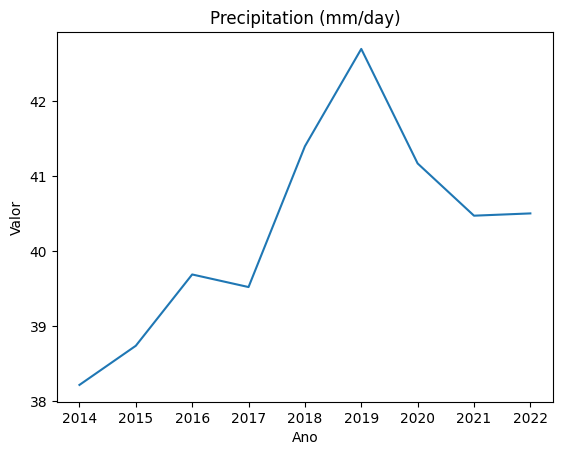

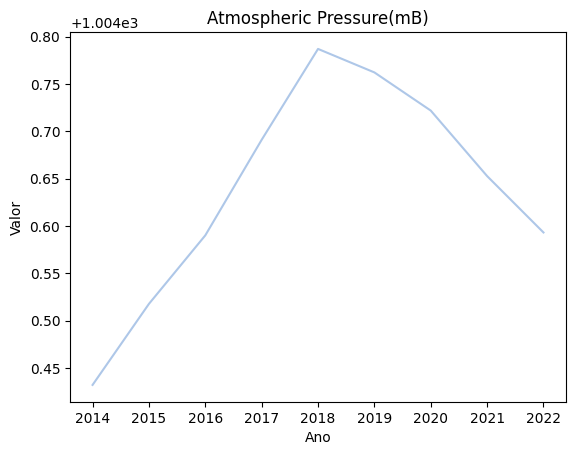

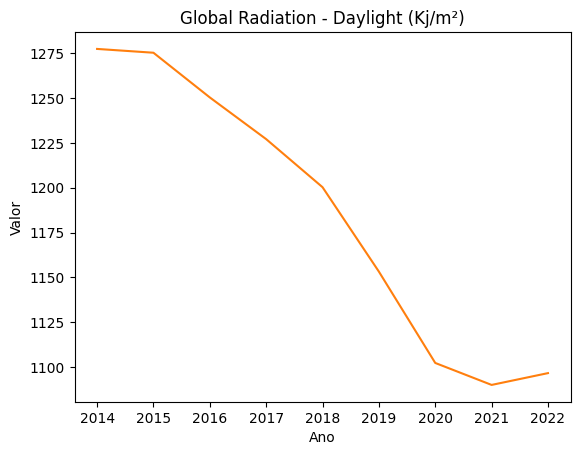

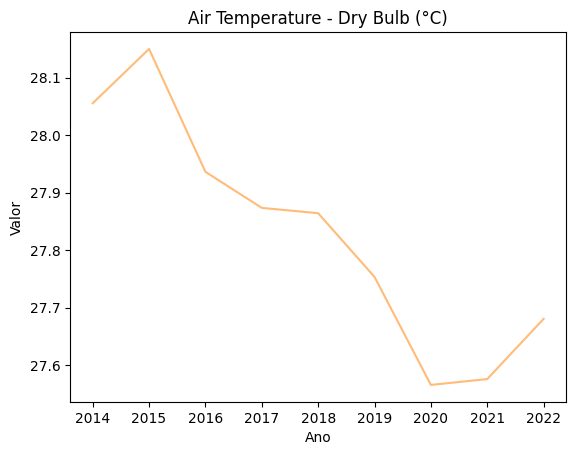

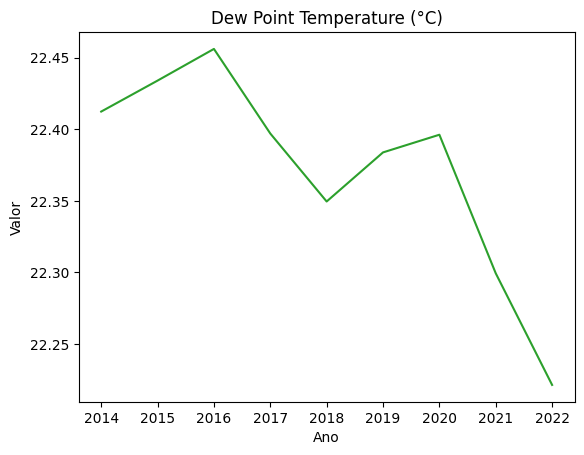

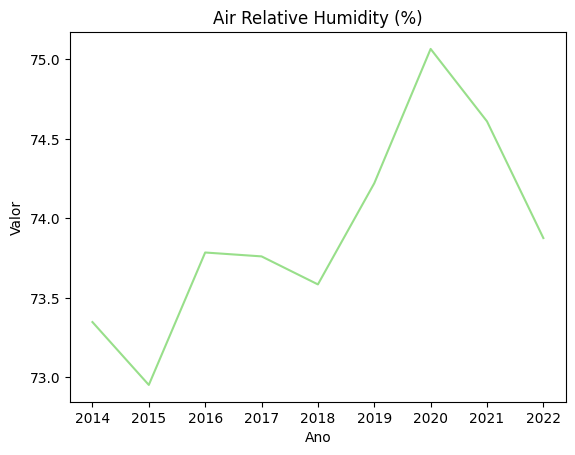

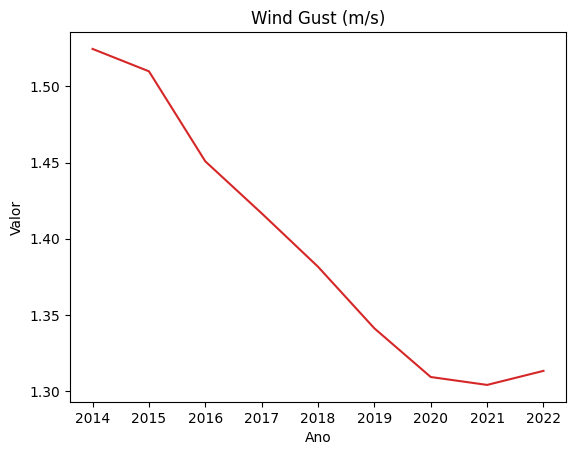

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2014,38.217511,1004.431965,1277.324904,28.055466,22.412378,73.347472,1.524622
2015,38.739113,1004.517645,1275.202120,28.150076,22.434009,72.952065,1.509930
2016,39.689203,1004.590070,1250.291696,27.936211,22.456139,73.785027,1.450843
2017,39.521434,1004.691076,1227.047962,27.873459,22.397053,73.760599,1.416718
2018,41.396833,1004.787155,1200.261326,27.864216,22.349568,73.584375,1.381646
2019,42.694126,1004.762314,1153.201551,27.753355,22.383859,74.220484,1.341209
2020,41.168367,1004.721967,1102.300417,27.565392,22.396203,75.065647,1.309276
2021,40.472299,1004.652726,1090.057669,27.575623,22.299417,74.609970,1.304082
2022,40.502582,1004.593122,1096.634990,27.680371,22.221446,73.875828,1.313308


In [9]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [10]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [11]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
Ano,,,,,,,
2008,29.241577,1002.673957,1407.801557,29.368351,23.012008,70.408467,1.658576
2009,30.906682,1002.901517,1393.526887,28.853124,22.769544,71.758162,1.685334
2010,35.544249,1003.401682,1311.661141,28.071885,22.643630,74.482804,1.537130
2011,39.206921,1003.835072,1276.962232,27.828830,22.427653,74.624578,1.468307
2012,40.620066,1004.045485,1269.809720,27.699098,22.391859,74.970536,1.457821
2013,39.498004,1004.283223,1266.017495,27.731222,22.404779,74.742115,1.485513
2014,38.217511,1004.431965,1277.324904,28.055466,22.412378,73.347472,1.524622
2015,38.739113,1004.517645,1275.202120,28.150076,22.434009,72.952065,1.509930
2016,39.689203,1004.590070,1250.291696,27.936211,22.456139,73.785027,1.450843


In [12]:
df_2008.to_csv('2008_01_meteo.csv', index=True)